In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
%gui qt

In [29]:
import seaborn as sns
from scipy import signal

In [6]:
t = np.load('task_replay.npz')['time']
pos = np.load('task_replay.npz')['pos']

In [202]:
t,pos

(array([0.000000e+00, 2.400000e-02, 3.900000e-02, ..., 2.986797e+03,
        2.986821e+03, 2.986836e+03]), array([[-76.03,  20.01],
        [-75.84,  19.74],
        [-75.63,  19.47],
        ...,
        [  8.8 , -40.36],
        [  8.8 , -40.36],
        [  8.8 , -40.36]]))

### Interpolation

In [7]:
from playground.utils import interp_pos

In [8]:
new_t, new_pos = interp_pos(t, pos)

In [9]:
dt = np.mean(np.diff(t))
dt

0.01789028049810423

In [9]:
np.diff(new_t)

array([0.01789028, 0.01789028, 0.01789028, ..., 0.01789028, 0.01789028,
       0.01789028])

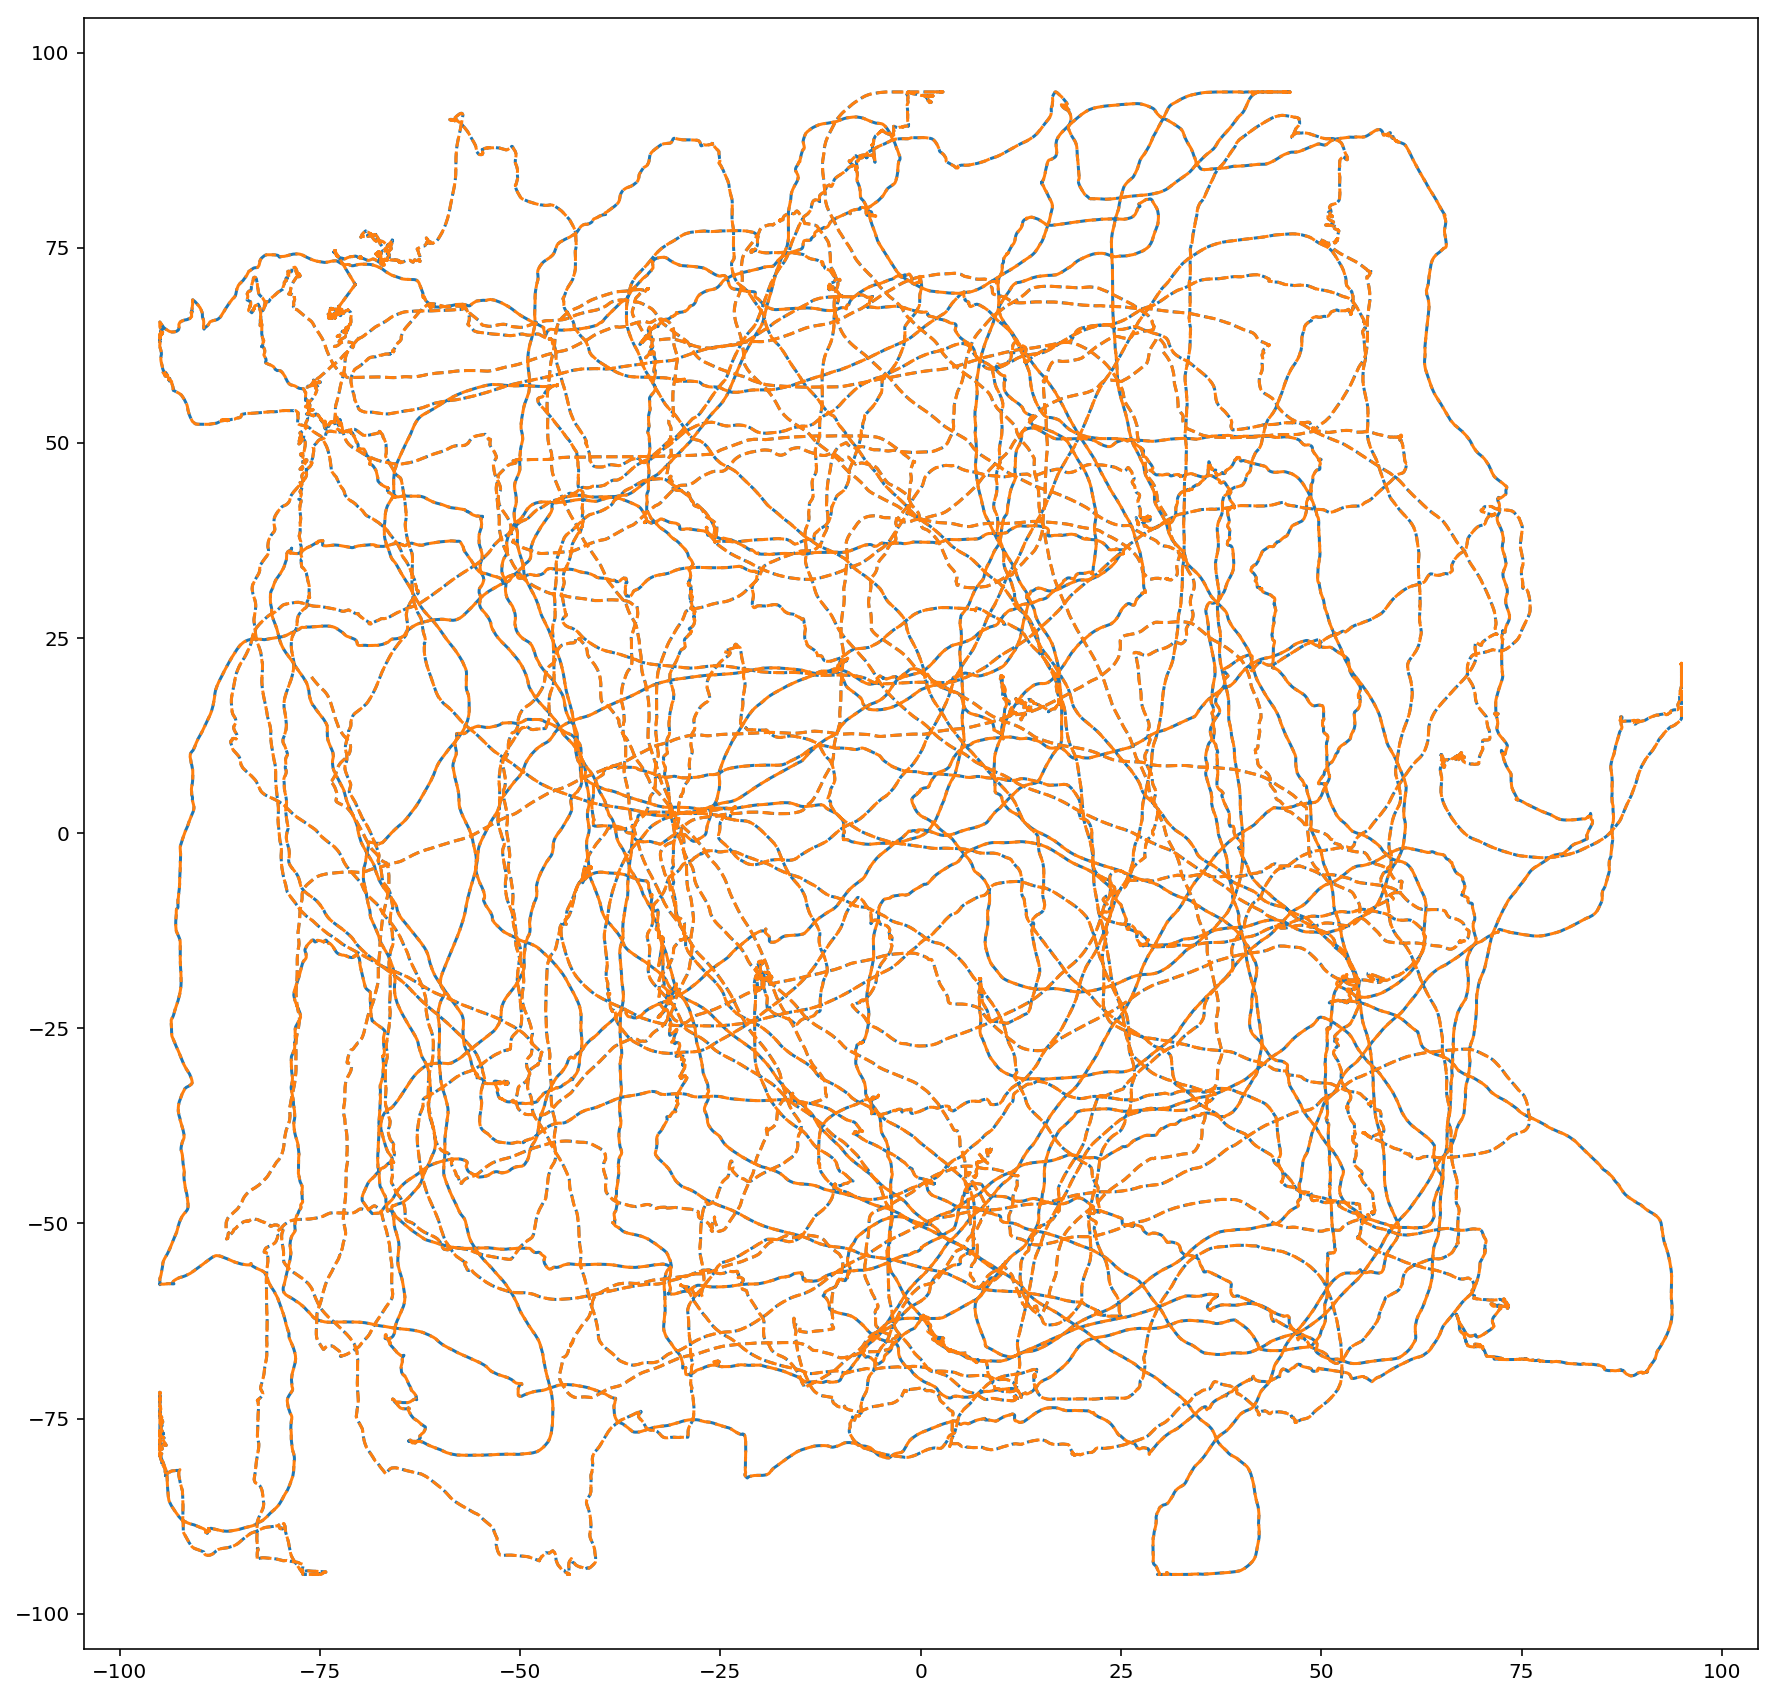

In [10]:
f, ax = subplots(1,1,figsize=(15,15))
plot(pos[:,0], pos[:,1], '--')
plot(new_pos[:,0], new_pos[:,1], '--')

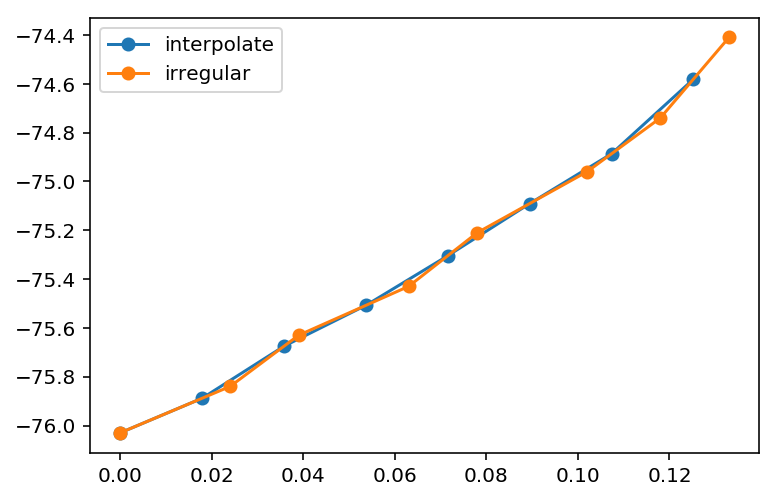

In [11]:
N = 8
plot(new_t[:N], new_pos[:N,0],  '-o', label='interpolate')
plot(t[:N], pos[:N,0], '-o', label='irregular')
legend()

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame(new_pos, columns=['x','y'], index=new_t)

In [14]:
df.head(10)

x          y
0.000000 -76.030000  20.010000
0.017890 -75.888369  19.808734
0.035781 -75.675072  19.527950
0.053671 -75.507743  19.323292
0.071561 -75.304437  19.081607
0.089451 -75.090715  18.841172
0.107342 -74.886552  18.629890
0.125232 -74.580897  18.340539
0.143122 -74.283472  18.011296
0.161013 -74.048475  17.667649

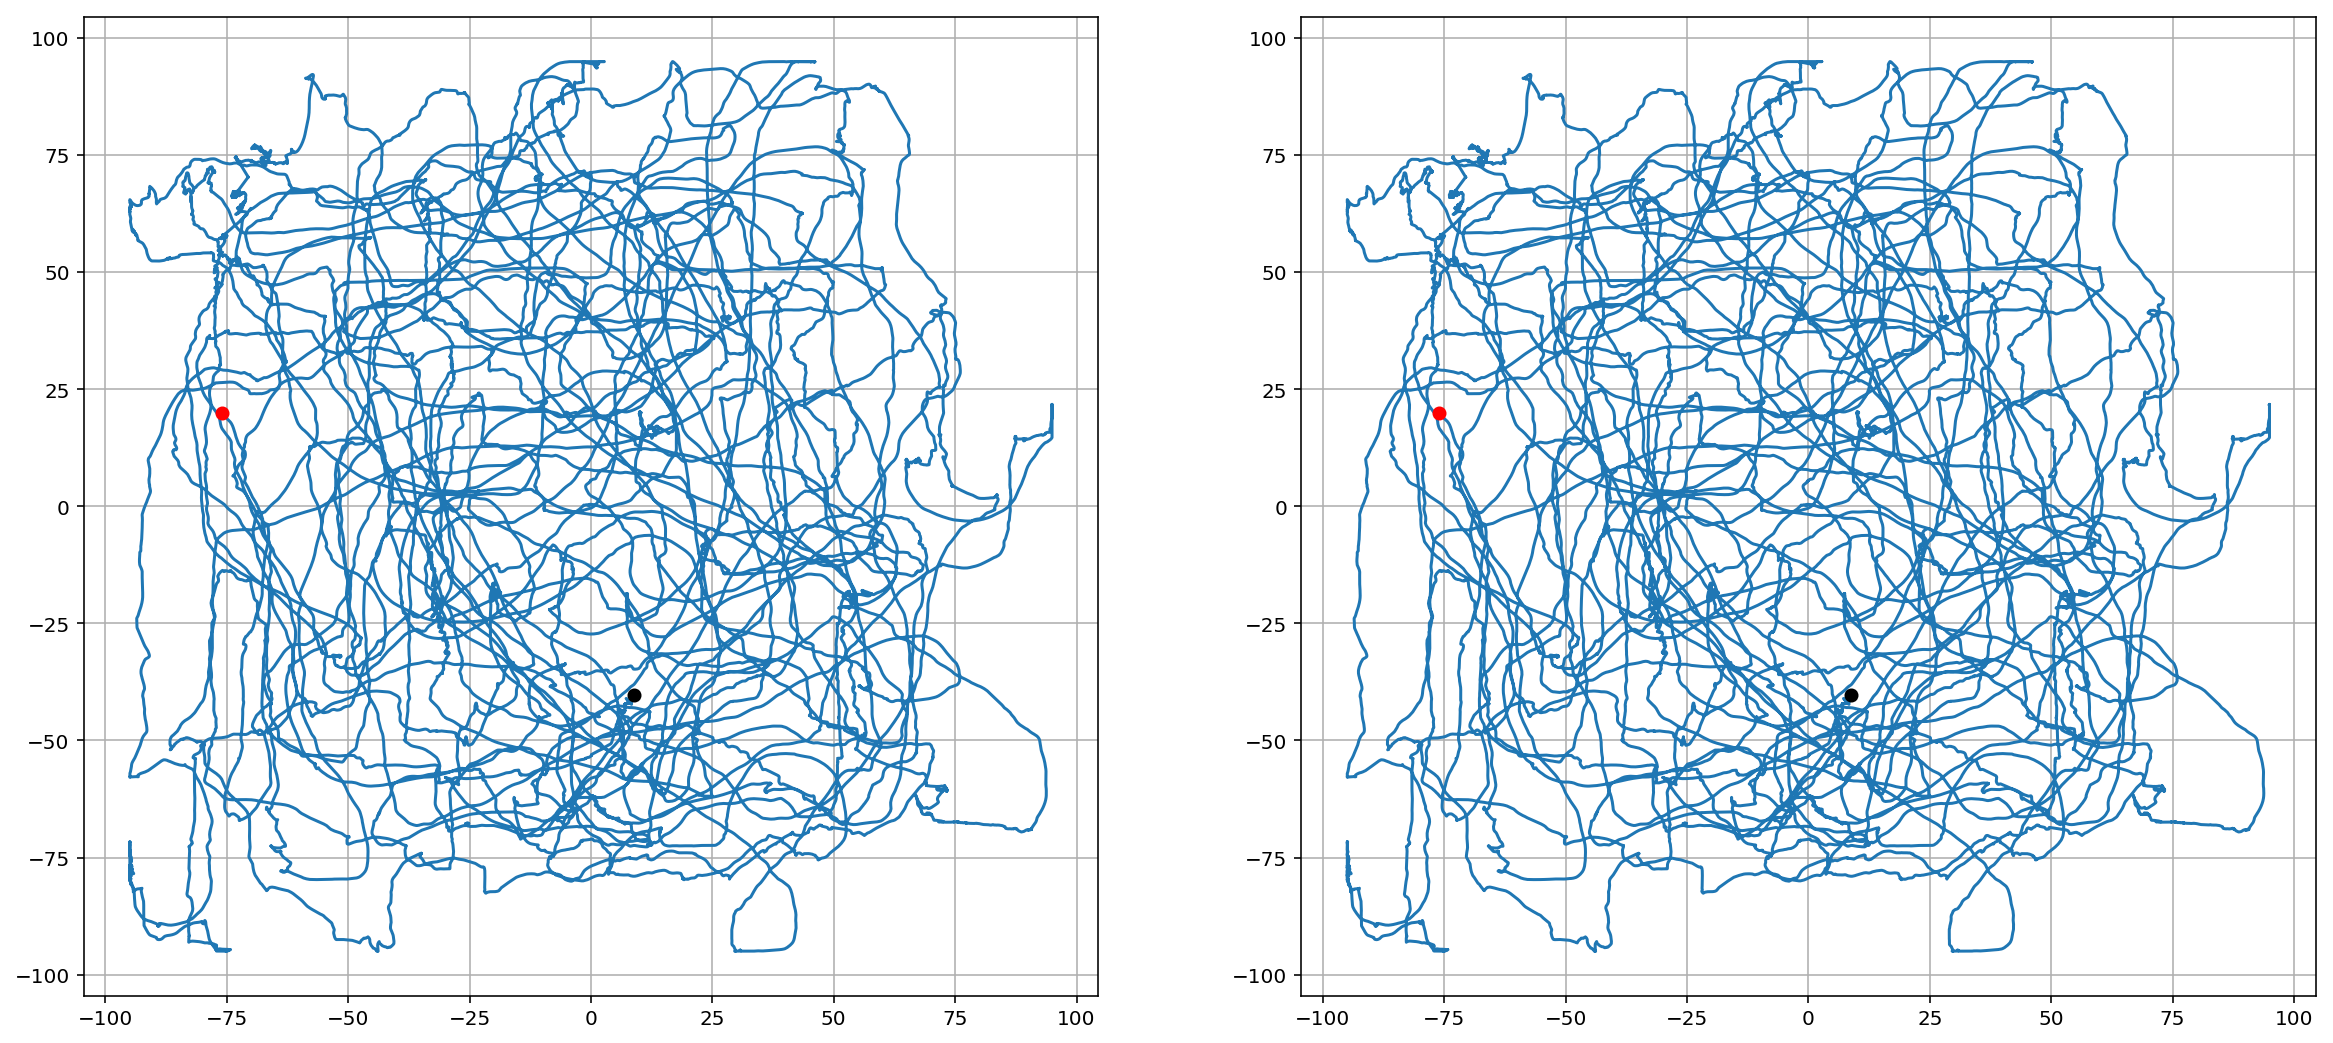

In [15]:
f, ax = plt.subplots(1,2,figsize=(20,9))
ax[0].plot(new_pos[:,0], new_pos[:,1])
ax[0].plot(new_pos[0,0], new_pos[0,1], 'ro')
ax[0].plot(new_pos[-1,0], new_pos[-1,1], 'ko')
ax[0].grid('on')

ax[1].plot(pos[:,0], pos[:,1])
ax[1].plot(pos[0,0], pos[0,1], 'ro')
ax[1].plot(pos[-1,0], pos[-1,1], 'ko')
ax[1].grid('on')

## Speed

In [16]:
v = np.linalg.norm(np.diff(new_pos, axis=0), axis=1)/np.diff(new_t)

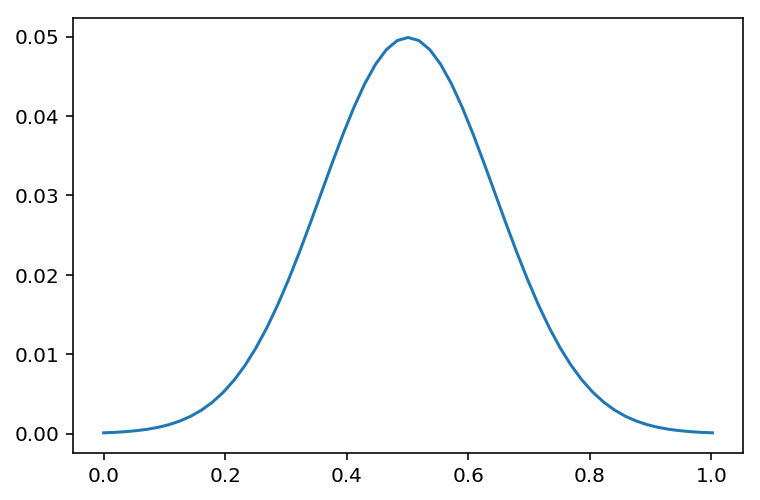

In [17]:
w = signal.gaussian(57, 8)
w/=sum(w)
plot(new_t[:w.shape[0]], w)

In [18]:
sum(v)

768883.4242387209

In [19]:
v_smoothed = np.convolve(v, w, mode='same')

In [20]:
sum(v_smoothed)

768821.3808860951

In [21]:
v = np.hstack((0, v))
v_smoothed = np.hstack((0, v_smoothed))

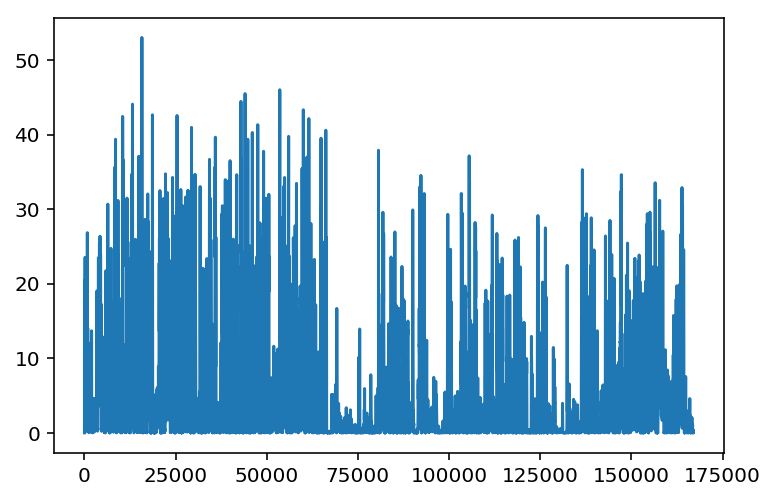

In [22]:
plot(v_smoothed)

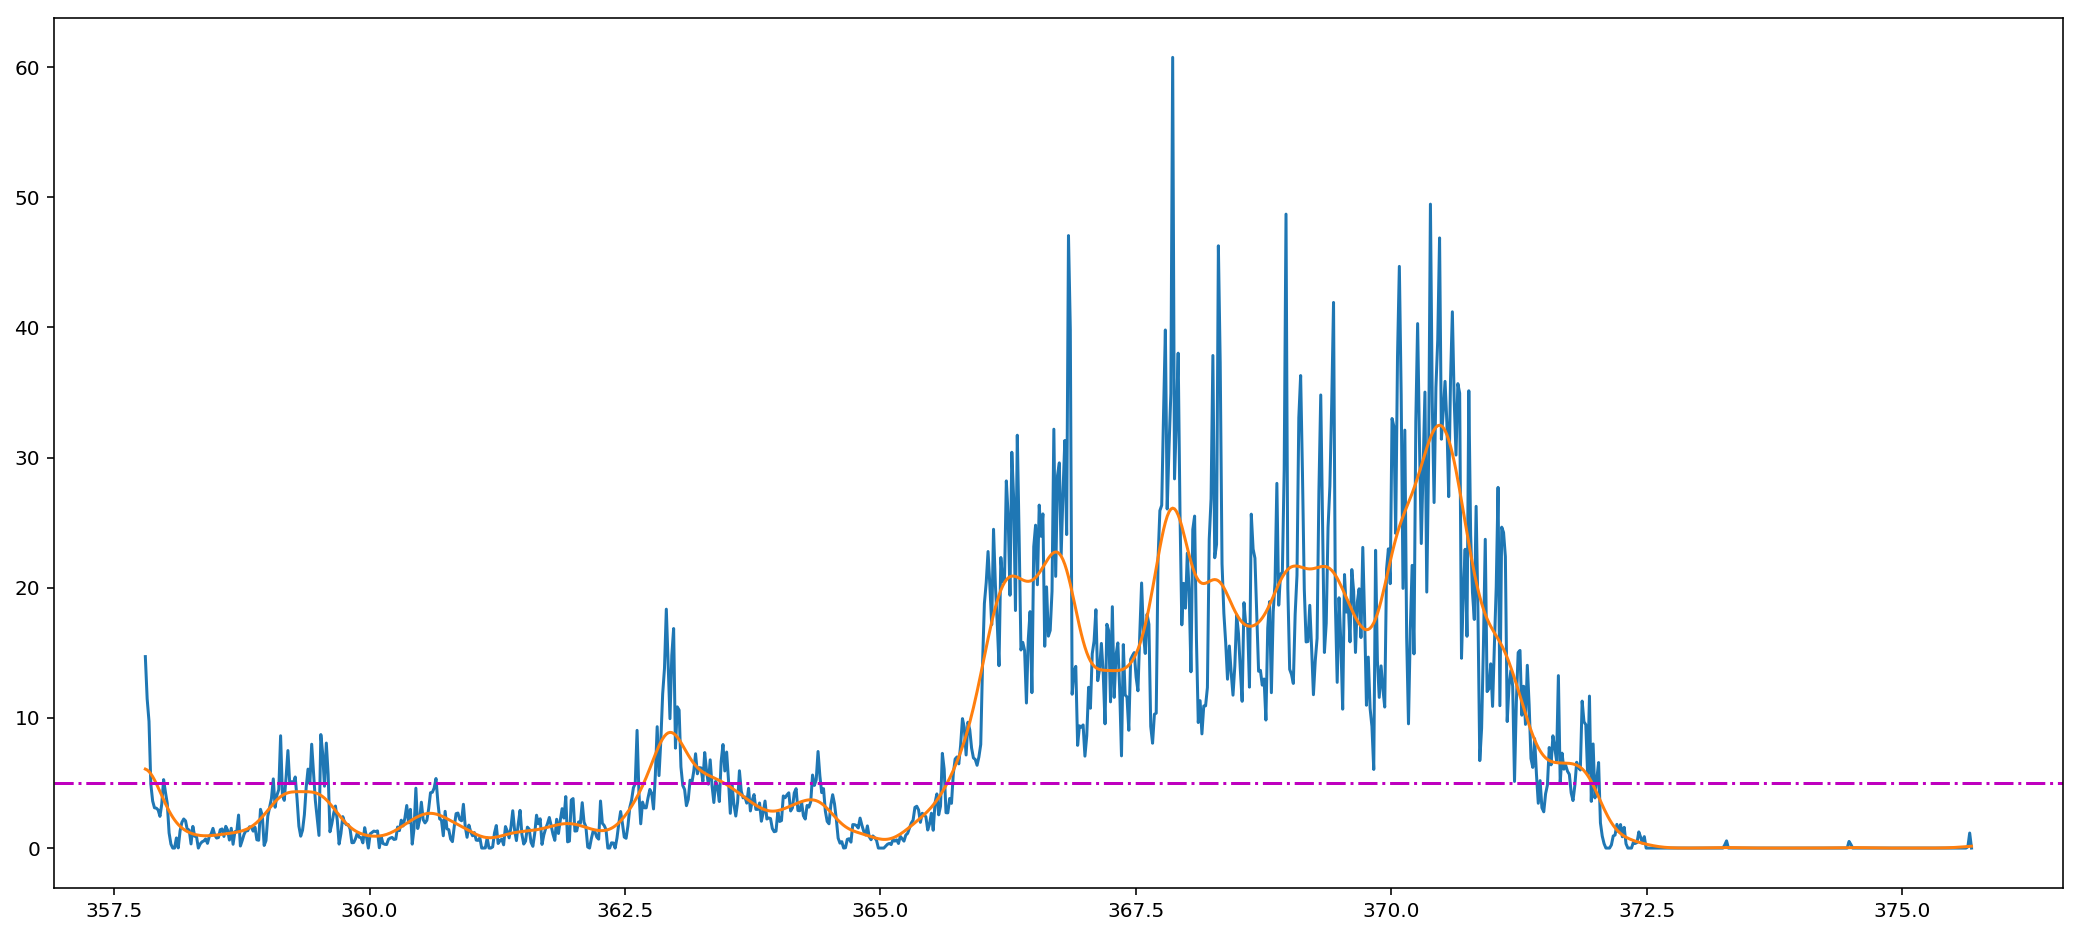

In [23]:
f, ax = plt.subplots(1,1, figsize=(18,8))
offset=20000
plot(new_t[offset:1000+offset], v[offset:1000+offset])
plot(new_t[offset:1000+offset], v_smoothed[offset:1000+offset])
ax.axhline(5, c='m', ls='-.')

In [24]:
v_clip_idx = np.where(v_smoothed<5)[0]
v_clip_idx

array([     0,     64,     65, ..., 166951, 166952, 166953])

In [25]:
v_clip_idx.shape[0]/float(new_t.shape[0])

0.7094469135210897

## Occupation map

> Position was binned (2 cm) and position tuning curves (place fields) were calculated as the smoothed (Gaussian kernel, st. dev. of 4 cm) histogram of firing activity normalized by the time spent per bin. Only periods of time when the rat was moving faster than 5 cm/s were used to determine place fields. Units were considered to have a place field if the unit was classified as excitatory and the peak of the tuning curve was >1 Hz. [Brad E Pfeiffer 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3990408/)

In [26]:
nbins = 200/2
nbins

100

In [27]:
occupation, x_edges, y_edges = np.histogram2d(x=new_pos[1:,0], y=new_pos[1:,1], 
                                             bins=nbins, range=[[-100,100], [-100,100]])

In [28]:
X, Y = np.meshgrid(x_edges, y_edges)
O = occupation.T.astype(int)  # Let each row list bins with common y range.

In [29]:
print O[::-1]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [30]:
v_smoothed[0] = 0.0001

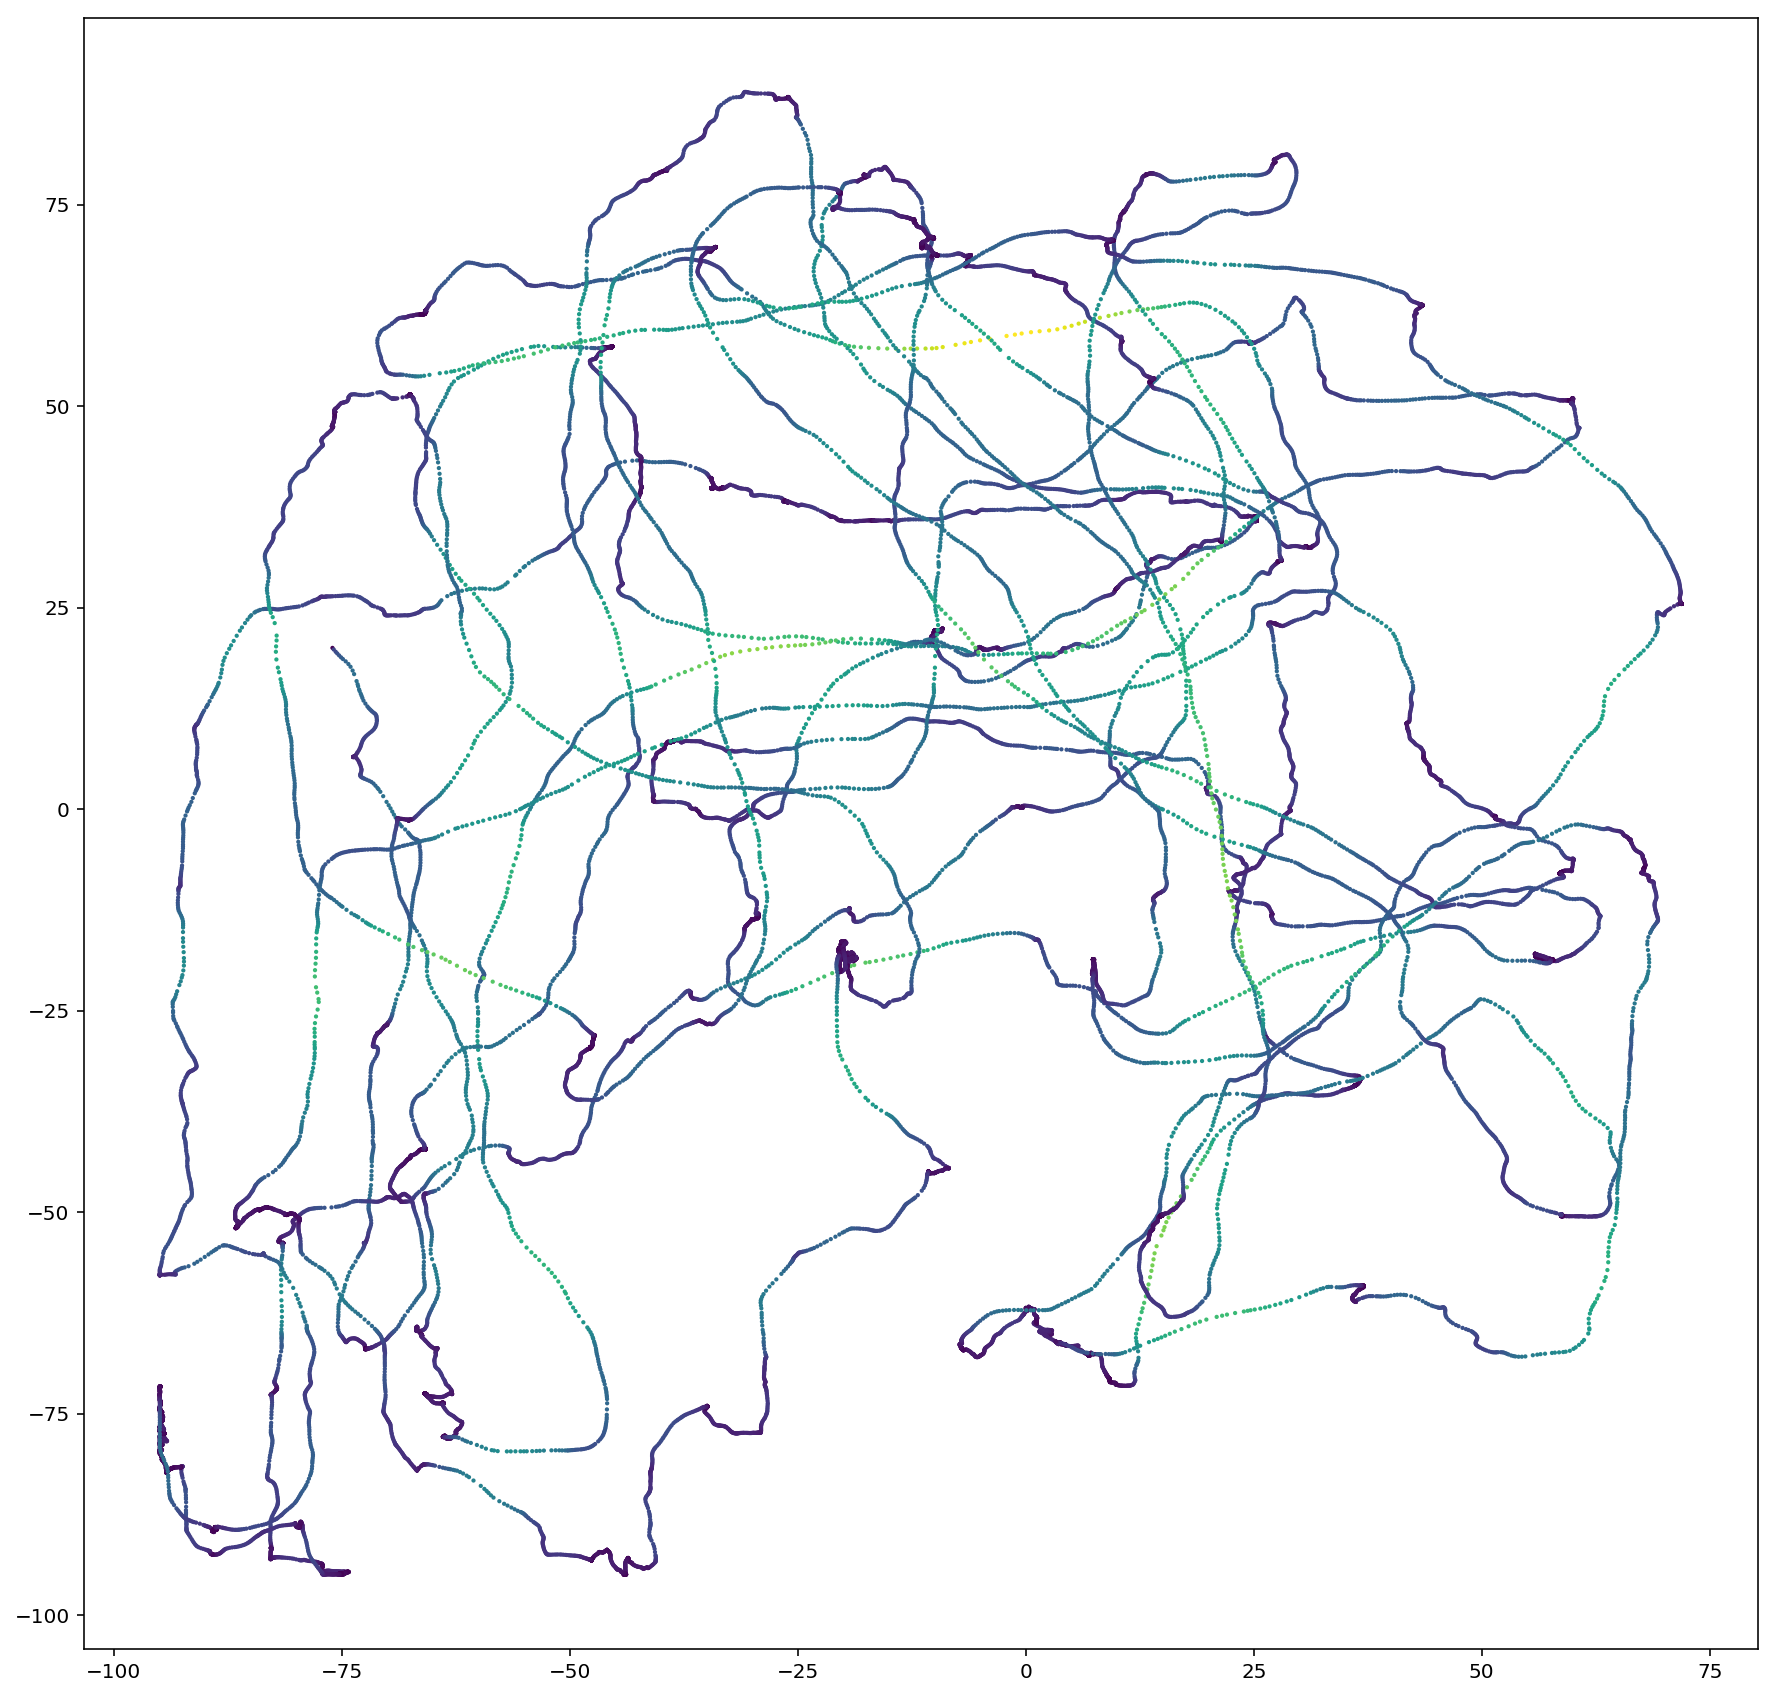

In [31]:
f, ax = plt.subplots(1,1,figsize=(15,15))
N = 40000
ax.scatter(new_pos[:N,0], new_pos[:N,1], marker='.', s=5, c=v_smoothed[:N]/max(v_smoothed[:N]))

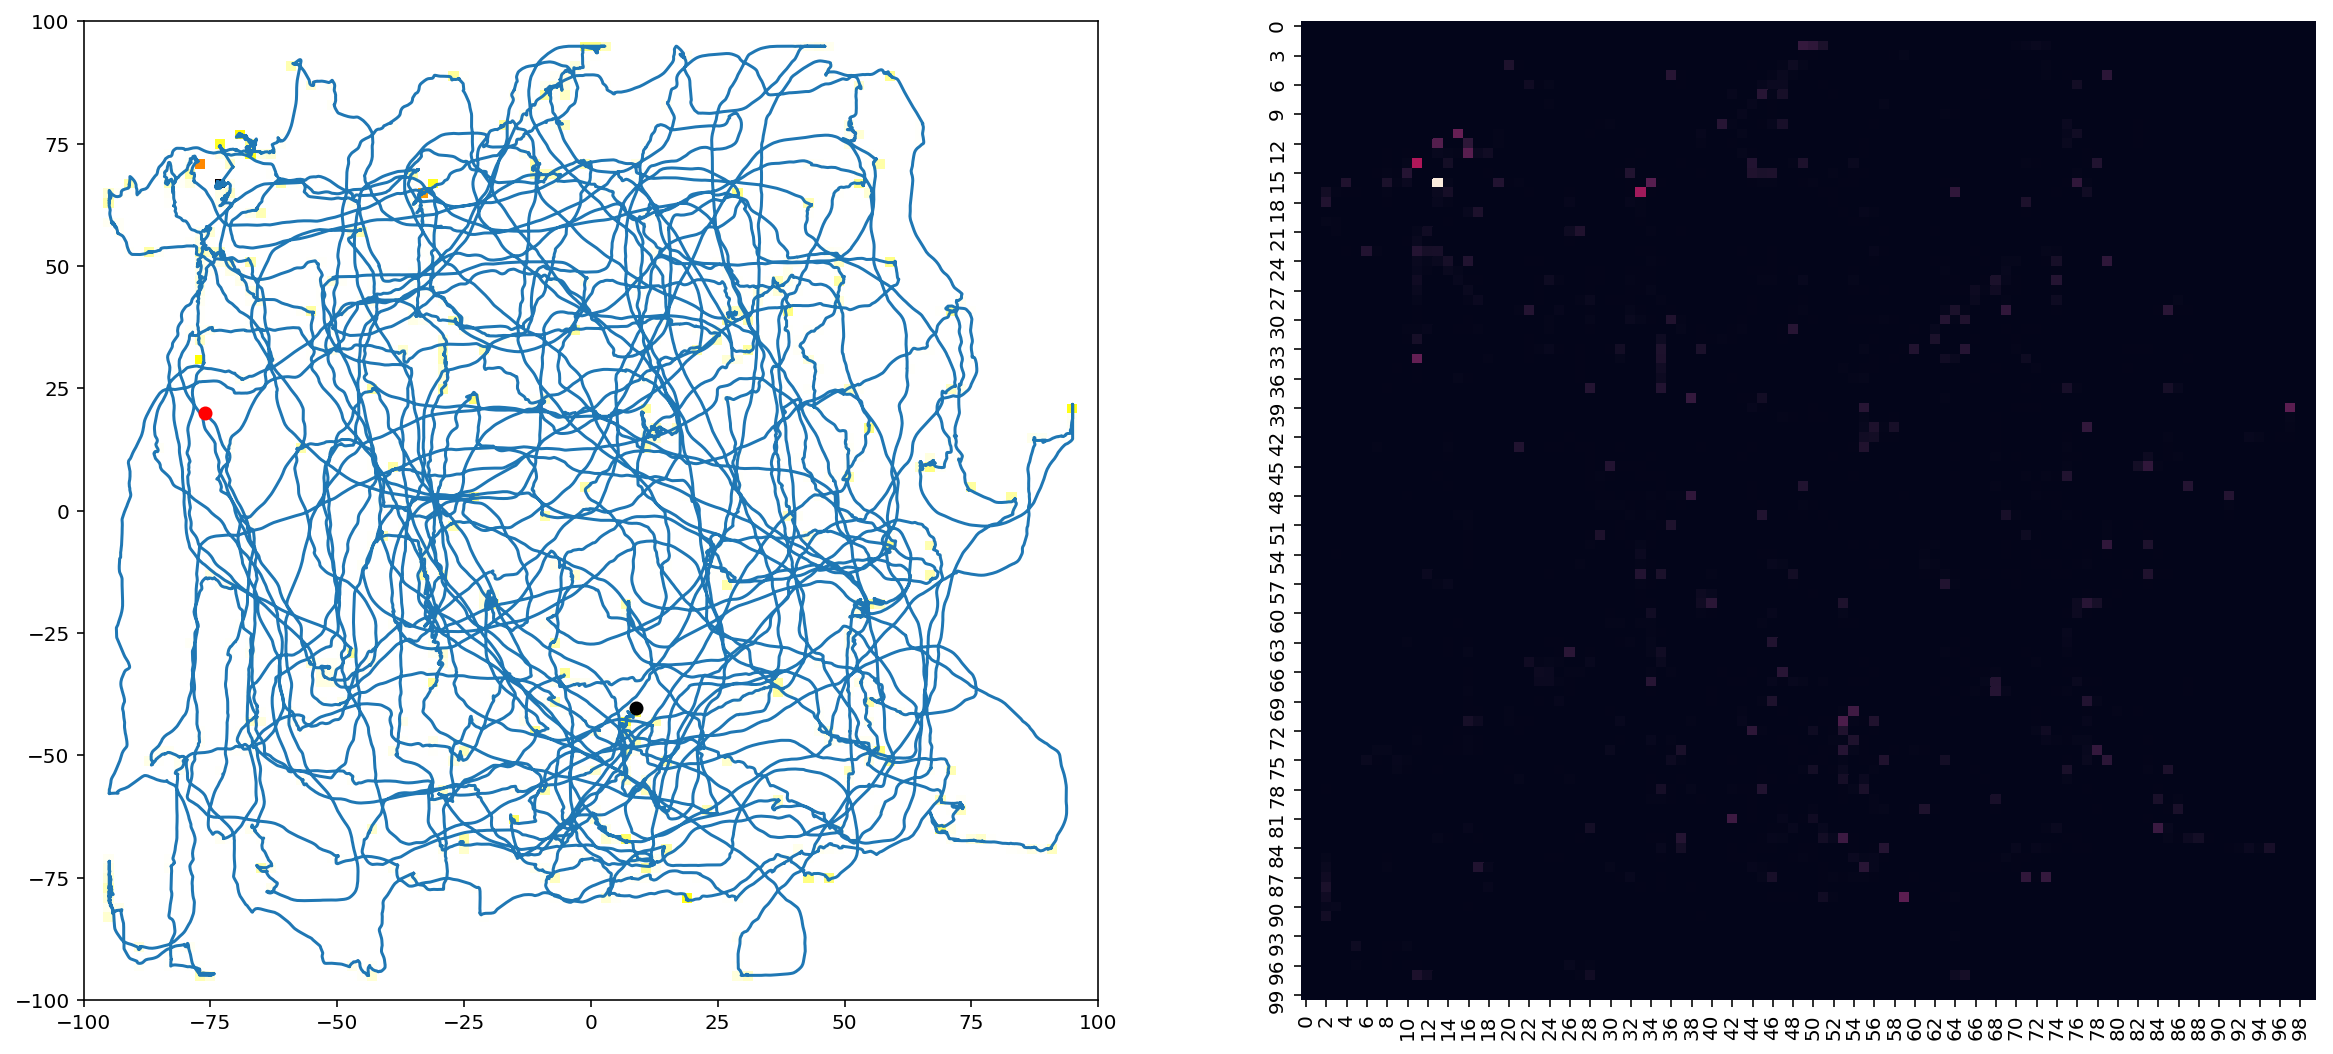

In [32]:
f, ax = plt.subplots(1,2,figsize=(20,9))
ax[0].plot(new_pos[:,0], new_pos[:,1])
ax[0].plot(new_pos[0,0], new_pos[0,1], 'ro')
ax[0].plot(new_pos[-1,0], new_pos[-1,1], 'ko')
ax[0].pcolormesh(X, Y, O, cmap=cm.hot_r)

# sns.heatmap(O[::-1]*dt, annot=True, fmt='.2f', cbar=False, ax=ax[1])
sns.heatmap(O[::-1]*dt, annot=False, cbar=False, ax=ax[1])

In [33]:
print(O[::-1]*dt)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
sum(O[::-1]*dt)

2986.8359999999957

In [35]:
t[-1]

2986.8359999999957

## Spike rate map

In [36]:
spk_t = np.load('./timing.npz')['timing'].item()

In [37]:
neuron_id = 8

In [38]:
spk_t[neuron_id]

array([ 934.95412,  954.37752,  955.85916, ..., 2949.40684, 2953.63212,
       2953.65796])

In [39]:
spk_tw = np.searchsorted(new_t, spk_t[neuron_id])
spk_tw = np.vstack((spk_tw-1, spk_tw)).T

In [40]:
spk_tw

array([[ 52260,  52261],
       [ 53346,  53347],
       [ 53428,  53429],
       ...,
       [164860, 164861],
       [165097, 165098],
       [165098, 165099]])

In [41]:
new_t[spk_tw][:,1].shape

(1717,)

In [42]:
new_t.shape

(166954,)

In [43]:
new_t[v_clip_idx].shape

(118445,)

In [44]:
new_t[spk_tw][:,1]

array([ 934.96394911,  954.39279373,  955.85979673, ..., 2949.4095332 ,
       2953.64952968, 2953.66741996])

In [45]:
idx = np.delete(spk_tw[:,1], v_clip_idx)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [46]:
firing_pos = new_pos[idx]

In [47]:
firing, x_edges, y_edges = np.histogram2d(x=firing_pos[:,0], y=firing_pos[:,1], 
                                             bins=nbins, range=[[-100,100], [-100,100]])

In [48]:
F = firing.T

In [49]:
sum(F)

811.0

In [50]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [51]:
FR = F/O/dt

In [52]:
FR

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [53]:
FR = np.nan_to_num(FR)

In [54]:
FR

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

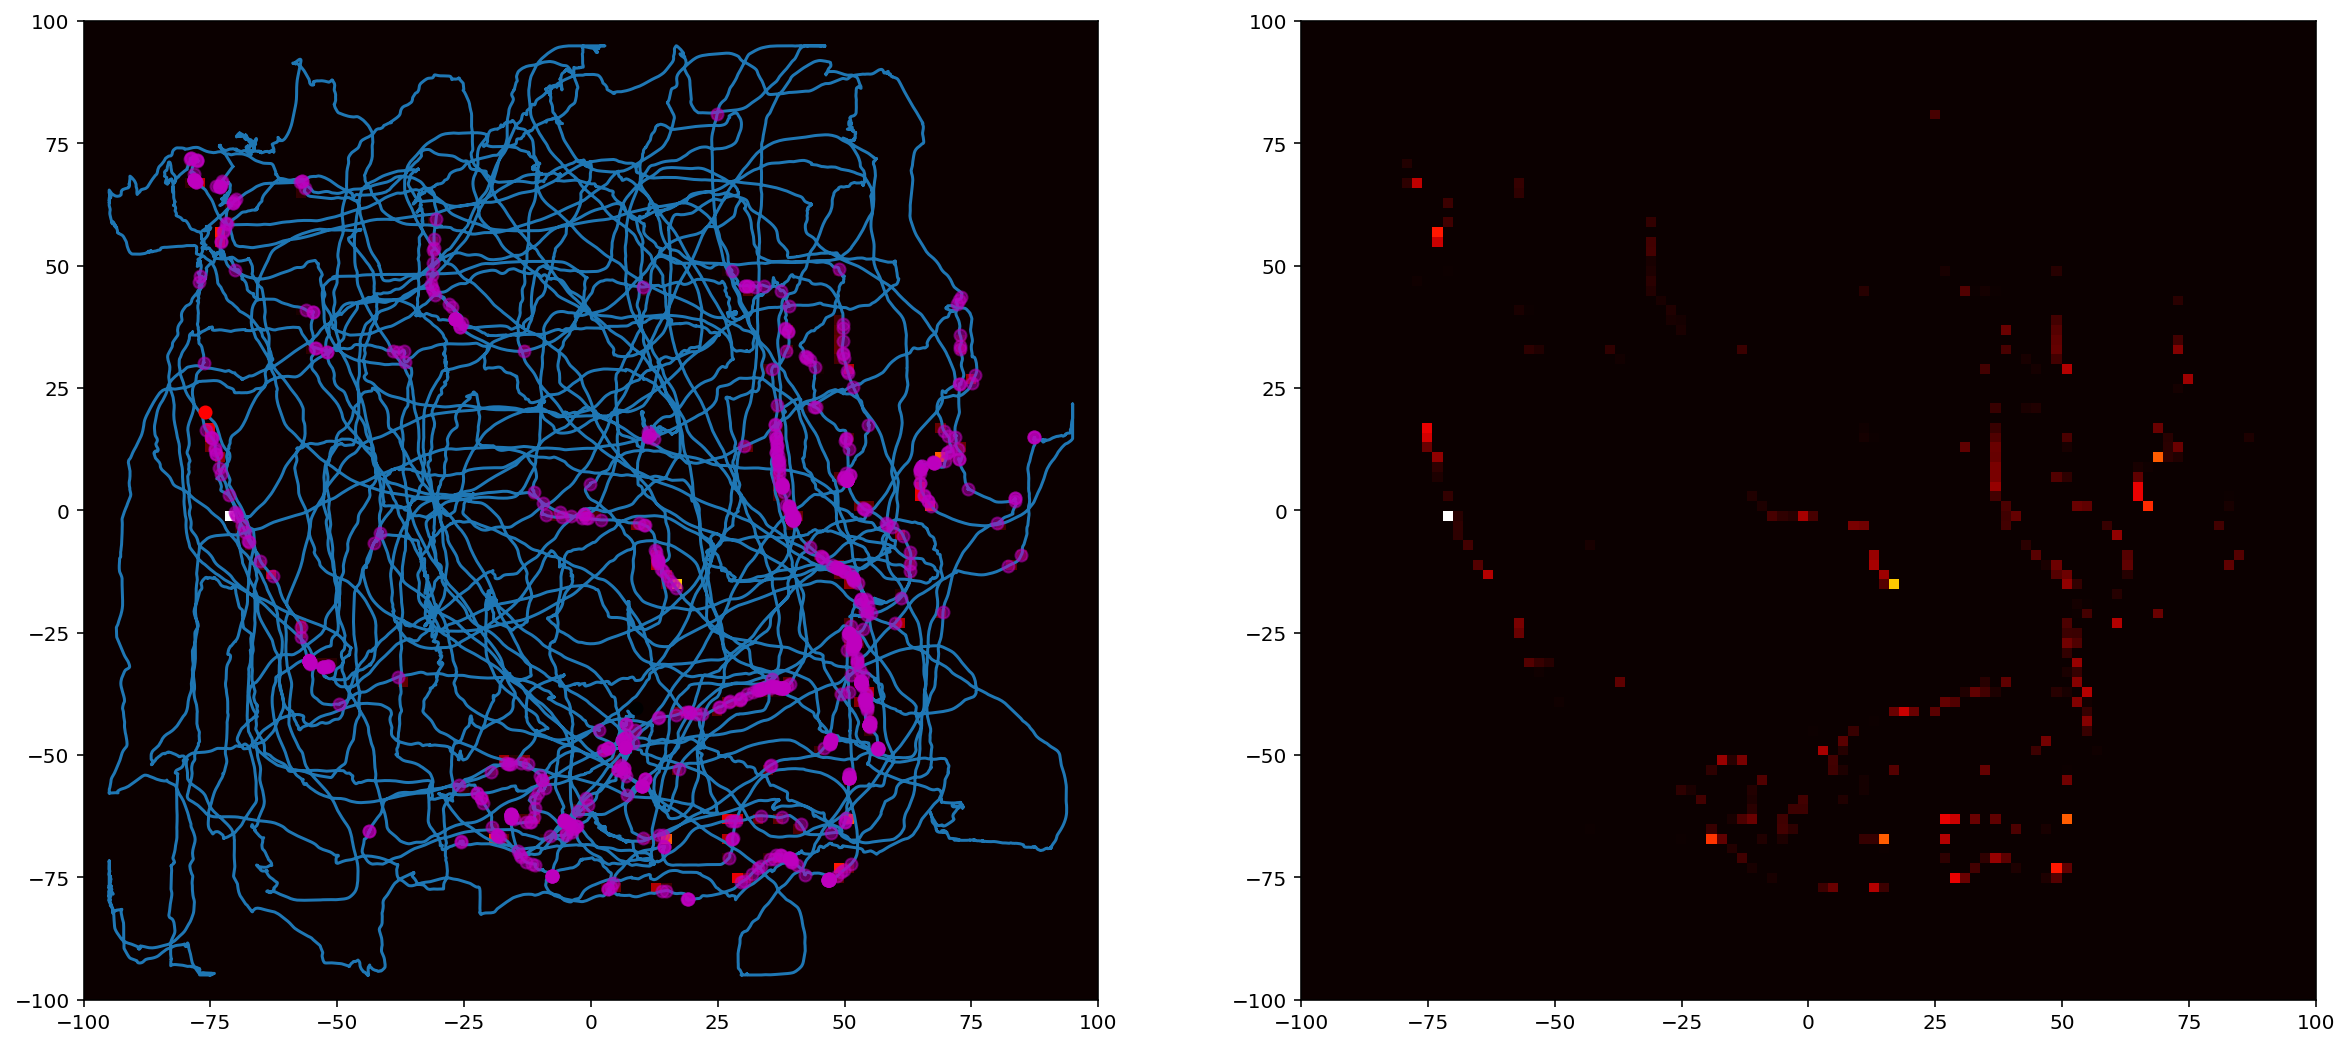

In [55]:
f, ax = plt.subplots(1,2,figsize=(20,9))
ax[0].plot(new_pos[:,0], new_pos[:,1])
ax[0].plot(new_pos[0,0], new_pos[0,1], 'ro')
ax[0].plot(new_pos[-1,0], new_pos[-1,1], 'ko')
ax[0].plot(firing_pos[:,0], firing_pos[:,1], 'mo', alpha=0.5)
ax[0].pcolormesh(X, Y, FR, cmap=cm.hot)
ax[1].pcolormesh(X, Y, FR, cmap=cm.hot)

# sns.heatmap(FR, cbar=False, ax=ax[1])

In [140]:
def gkern(kernlen=21, std=2):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    gkern2d /= sum(gkern2d)
    return gkern2d

In [141]:
gkern(10,3).shape

(10, 10)

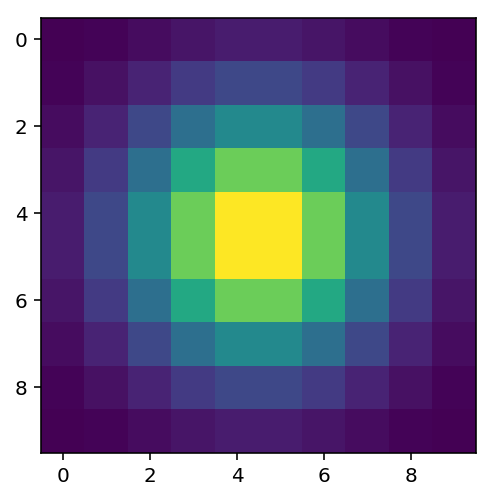

In [142]:
imshow(gkern(10,2), interpolation='none')

In [201]:
FR.max()

55.89627284524502

In [197]:
FR_GAU = signal.convolve2d(FR, gkern(12, 3), boundary='symm', mode='same')

In [198]:
FR.shape

(100, 100)

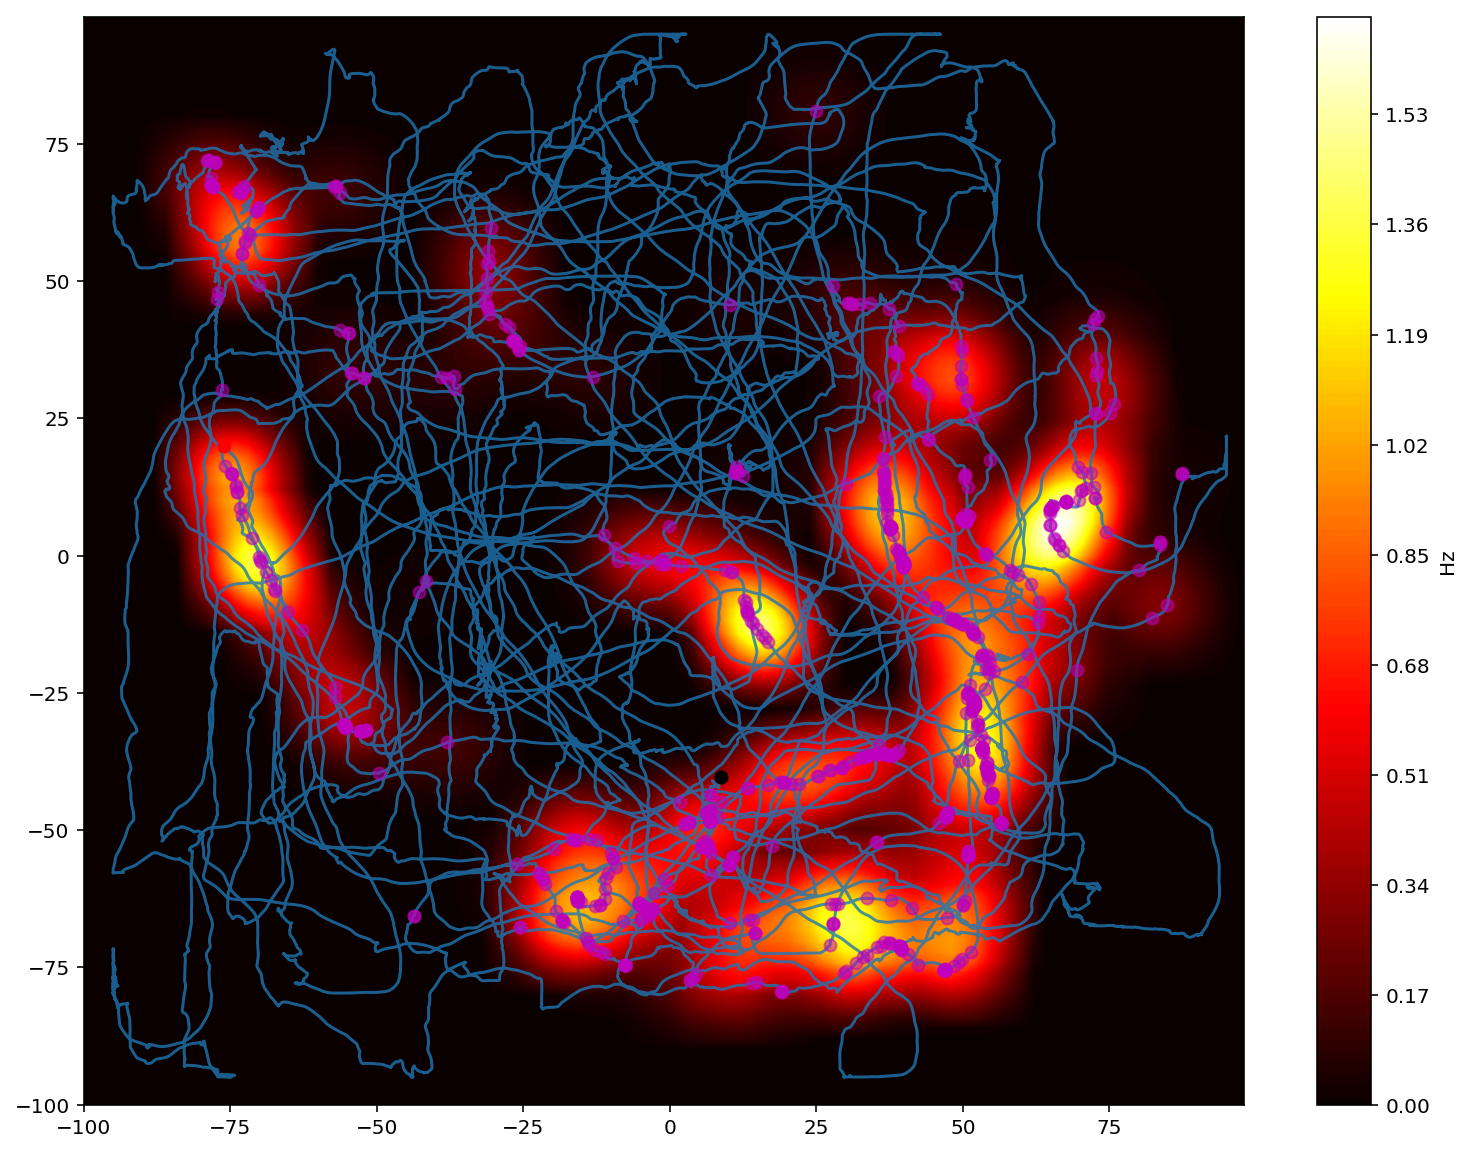

In [200]:
f, ax = plt.subplots(1,1,figsize=(13,10))
ax.plot(new_pos[:,0], new_pos[:,1], alpha=0.8)
ax.plot(new_pos[0,0], new_pos[0,1], 'ro')
ax.plot(new_pos[-1,0], new_pos[-1,1], 'ko')
ax.plot(firing_pos[:,0], firing_pos[:,1], 'mo', alpha=0.5)
# pc = ax.pcolormesh(X, Y, FR_GAU, cmap=cm.hot)
# colorbar(pc, ax=ax) 
pc = ax.contourf(X[:-1, :-1], Y[:-1,:-1], FR_GAU, cmap=cm.hot, levels=np.arange(FR_GAU.min(),FR_GAU.max(),0.01))
cb = colorbar(pc, ax=ax, label='Hz') 
# cb.legend()

In [173]:
FR.sum()

1591.4265514102751

In [179]:
FR_GAU.max()

1.6822809890957373

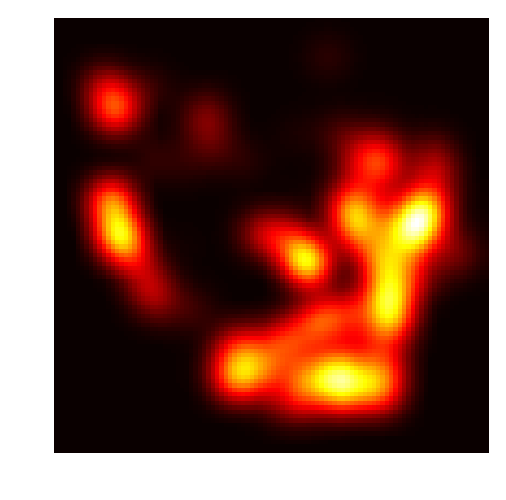

In [116]:
imshow(FR_GAU, origin='low', cmap=cm.hot);
axis('off');